# Model Building 

## Data Pipeline
Tensorflow works best when data is organized into an input pipeline.  These pipelines help organize, batch, shuffle, and serve your data to CPU/GPU during learning.   The [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) module API assists with this.  

The main structure is the `tf.data.Dataset` object.  It loads data from disk, applies optimized transformations, creates batches, and sends it to CPU/GPU.  

[Google blog post on tf.data.Datasets](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)   
[Tutorial on tf.data](https://www.tensorflow.org/guide/data)   
[Advanced guide on tf.data](https://www.tensorflow.org/guide/data)   

--- 


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers 

from PIL import Image 

print(tf.__version__)

2.1.0


### Read X, y from files 
Preprocessing is done in `munge-data.ipynb`

In [2]:
y_train_bin = np.loadtxt('data/munged/y_train.csv', delimiter=',') 
y_val_bin = np.loadtxt('data/munged/y_val.csv', delimiter=',') 
y_test_bin = np.loadtxt('data/munged/y_test.csv', delimiter=',') 

In [3]:
X_train = np.loadtxt('data/munged/X_train.csv', dtype=str)
X_val = np.loadtxt('data/munged/X_val.csv', dtype=str)
X_test = np.loadtxt('data/munged/X_test.csv', dtype=str)

Verify data shapes 

In [4]:
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((691, 18), (77, 18), (41, 18))

In [5]:
len(X_train), len(X_val), len(X_test)

(691, 77, 41)

Read labels from file 

In [6]:
import json 

with open('data/munged/labels.json') as json_file:
    type_encoding = json.load(json_file)

# convert string keys to ints 
type_encoding = {int(k):v for k, v in type_encoding.items()}

type_encoding

{0: 'Bug',
 1: 'Dark',
 2: 'Dragon',
 3: 'Electric',
 4: 'Fairy',
 5: 'Fighting',
 6: 'Fire',
 7: 'Flying',
 8: 'Ghost',
 9: 'Grass',
 10: 'Ground',
 11: 'Ice',
 12: 'Normal',
 13: 'Poison',
 14: 'Psychic',
 15: 'Rock',
 16: 'Steel',
 17: 'Water'}

### Build Pipeline 

We are ready to build the tf.data.Dataset.  In these functions, you _must_ use tf API and operate with tensor objects.  

In [21]:
from importlib import reload 
import utils 
reload(utils)

<module 'utils' from 'C:\\Users\\rshn\\Developer\\kaggle\\pokemon-types\\utils.py'>

In [8]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of 8 observations

In [9]:
train_augment_ds = utils.create_dataset(X_train, y_train_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=True)
train_ds = utils.create_dataset(X_train, y_train_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=False)
val_ds = utils.create_dataset(X_val, y_val_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=False)
test_ds = utils.create_dataset(X_test, y_test_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE, augment=False)

## Examine the `tf.data.Dataset`

Shapes of items in dataset: 
```
features:  (BATCH SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)    
label:     (BATCH_SIZE, N_LABELS)

```

Shape of features array: (32, 120, 120, 3)
Shape of labels array: (32, 18)

Plot one of the images from the first batch


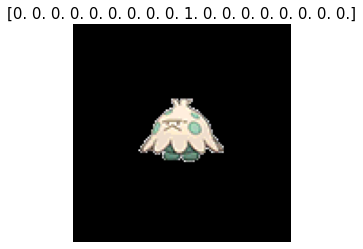

In [10]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
    print("\nPlot one of the images from the first batch")
    plt.imshow(f[0])
    plt.title(str(l.numpy()[0]), size=15)
    plt.axis(False)

Use .take(n) to gave `n` batches.  We set batch_size to 32.  

## Concatenating augmented dataset and regular dataset 

In [11]:
train_ds = train_ds.concatenate(train_augment_ds)

Print samples of training images 

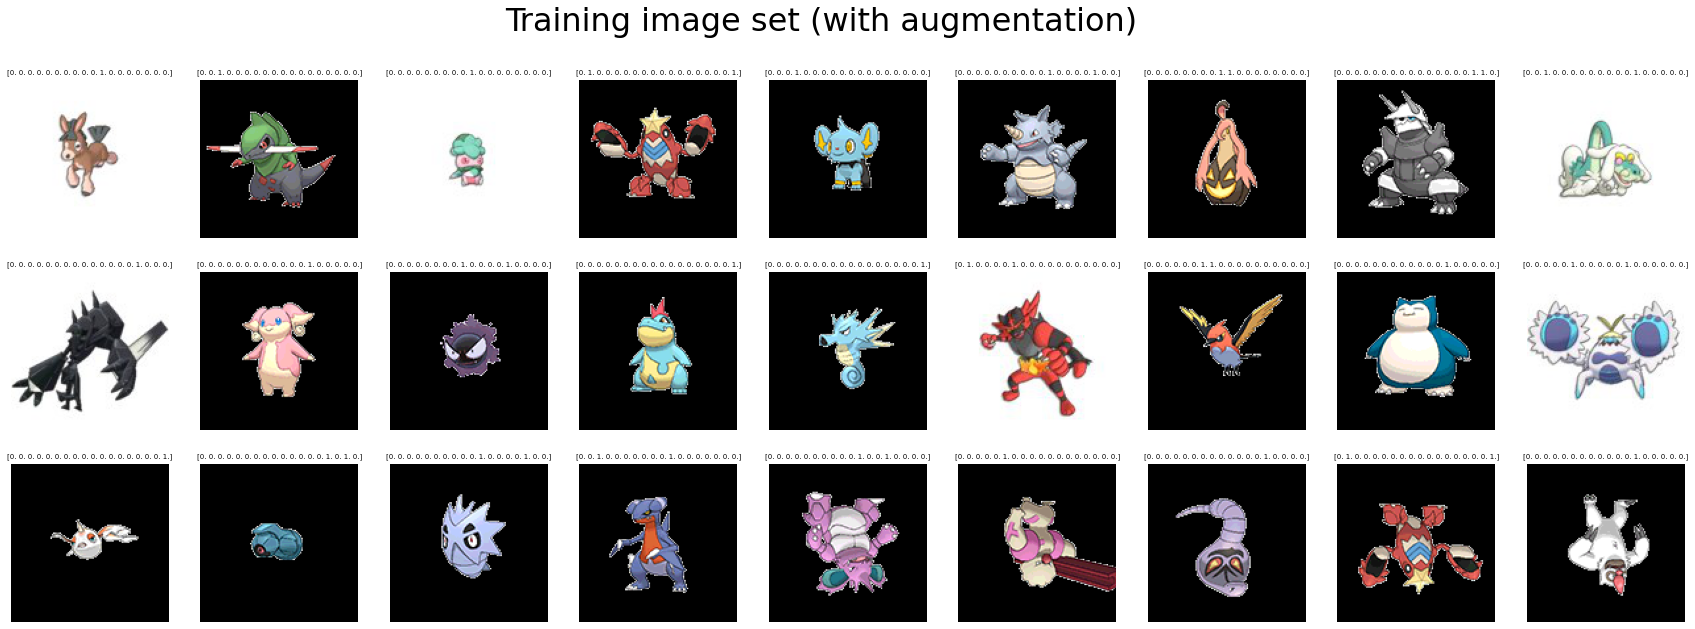

In [91]:
fig, axes = plt.subplots(3, 9, figsize=(30, 10))
axes = axes.reshape(-1)

fig.suptitle('Training image set (with augmentation)', fontsize=32)

for idx, (f, l) in enumerate(train_ds.take(3*9)):
    axes[idx].imshow(f[0])
    axes[idx].set_title(str(l.numpy()[0]), size=7)
    axes[idx].axis(False)


# Model Building 



In [75]:
img = Image.open('data/bulbasaur.png')
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
CHANNELS = 3  
N_LABELS = 18

In [76]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout   

model = tf.keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)), 
    MaxPooling2D((2, 2)),   
    
    Conv2D(32, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 
    
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 

    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 
    
    Conv2D(150, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 
    
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(N_LABELS), 
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 128)      

In [77]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

callbacks = [early_stopping]

### Train model 

In [79]:
history = model.fit(train_ds, 
                   epochs=500, 
                   validation_data=val_ds, 
                   callbacks=callbacks, 
                   verbose=1)

Train for 44 steps, validate for 3 steps
Epoch 1/500
44/44 [==============================] - 1s 28ms/step - loss: 0.5700 - top_k_categorical_accuracy: 0.1223 - val_loss: 0.3895 - val_top_k_categorical_accuracy: 0.1558
Epoch 2/500
44/44 [==============================] - 1s 12ms/step - loss: 0.3376 - top_k_categorical_accuracy: 0.1172 - val_loss: 0.3176 - val_top_k_categorical_accuracy: 0.1299
Epoch 3/500
44/44 [==============================] - 1s 12ms/step - loss: 0.3022 - top_k_categorical_accuracy: 0.1237 - val_loss: 0.2950 - val_top_k_categorical_accuracy: 0.1039
Epoch 4/500
44/44 [==============================] - 1s 12ms/step - loss: 0.2884 - top_k_categorical_accuracy: 0.1548 - val_loss: 0.2912 - val_top_k_categorical_accuracy: 0.1039
Epoch 5/500
44/44 [==============================] - 1s 12ms/step - loss: 0.2825 - top_k_categorical_accuracy: 0.1621 - val_loss: 0.2872 - val_top_k_categorical_accuracy: 0.1169
Epoch 6/500
44/44 [==============================] - 1s 12ms/step - l

44/44 [==============================] - 1s 12ms/step - loss: 0.2134 - top_k_categorical_accuracy: 0.5022 - val_loss: 0.2710 - val_top_k_categorical_accuracy: 0.3117
Epoch 47/500
44/44 [==============================] - 1s 12ms/step - loss: 0.2113 - top_k_categorical_accuracy: 0.5137 - val_loss: 0.2735 - val_top_k_categorical_accuracy: 0.2987
Epoch 48/500
44/44 [==============================] - 1s 13ms/step - loss: 0.2085 - top_k_categorical_accuracy: 0.5297 - val_loss: 0.2766 - val_top_k_categorical_accuracy: 0.3377
Epoch 49/500
44/44 [==============================] - 1s 12ms/step - loss: 0.2058 - top_k_categorical_accuracy: 0.5362 - val_loss: 0.2792 - val_top_k_categorical_accuracy: 0.3377
Epoch 50/500
44/44 [==============================] - 1s 12ms/step - loss: 0.2035 - top_k_categorical_accuracy: 0.5434 - val_loss: 0.2786 - val_top_k_categorical_accuracy: 0.3117
Epoch 51/500
44/44 [==============================] - 1s 12ms/step - loss: 0.2010 - top_k_categorical_accuracy: 0.5608

### Plot the learning curves 

2/2 - 0s - loss: 0.2783 - top_k_categorical_accuracy: 0.3171


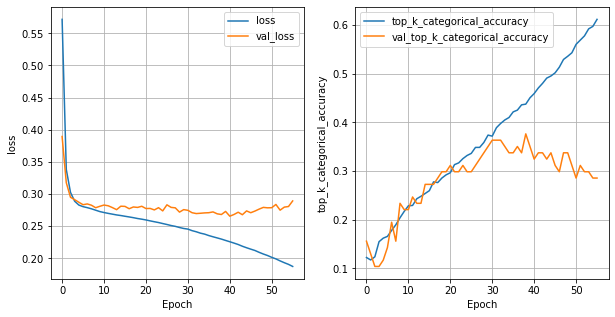

In [80]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

## Visualize results 

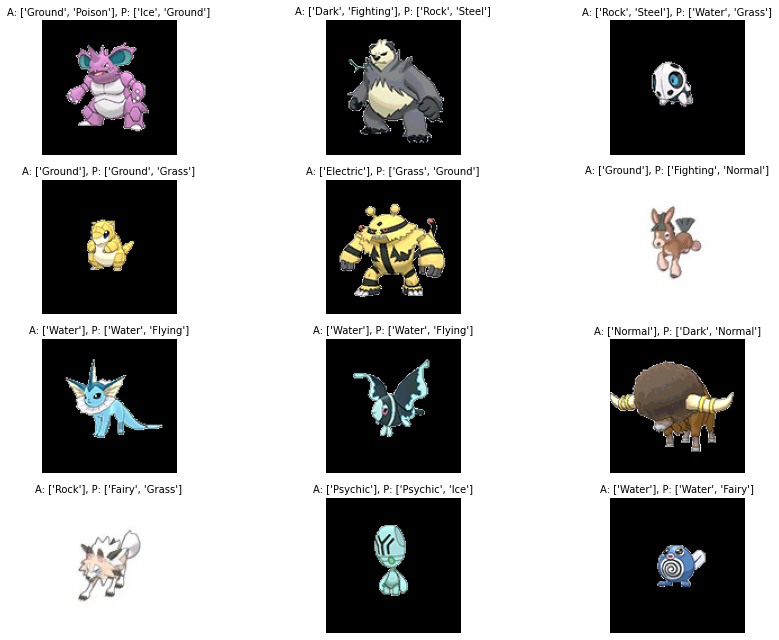

In [89]:
# Training data 
utils.plot_prediction_grid(model, train_ds, (4, 3), True)
plt.tight_layout()

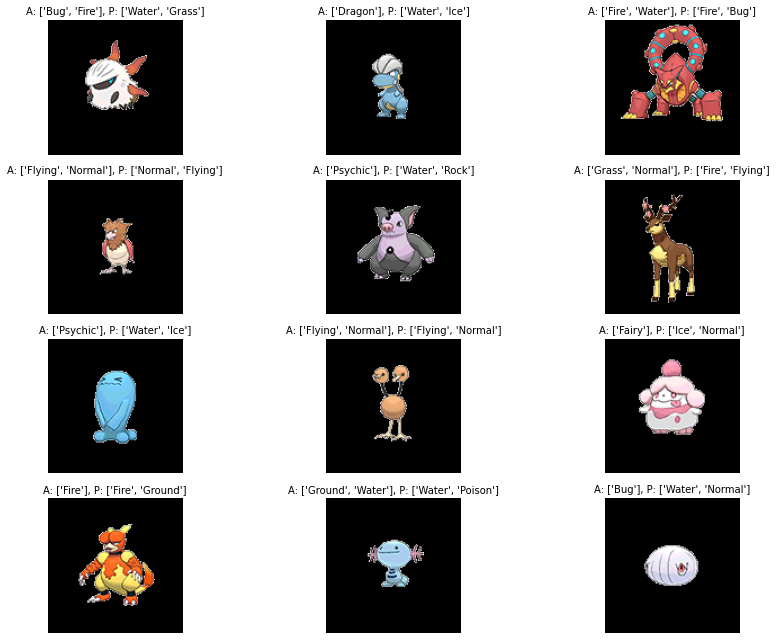

In [84]:
## Test on test_set 
utils.plot_prediction_grid(model, test_ds, (4, 3), True)
plt.tight_layout()

---
---
---

## Save model 

In [93]:
from datetime import datetime
import os 

date_time = datetime.now().strftime("%Y%m%d-%H%M%S")
dirname = "saved_models/" + date_time + "-aug-bce"

os.mkdir(dirname)
model.save(dirname)

INFO:tensorflow:Assets written to: saved_models/20200712-123359-aug-bce\assets


### load model and test 

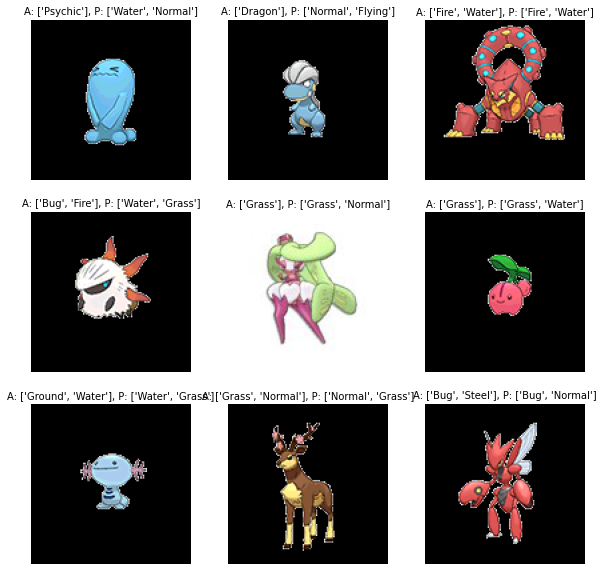

In [30]:
new_model = tf.keras.models.load_model('saved_models/20200627-133409-baseline')

## Test on test_set 
utils.plot_prediction_grid(new_model, test_ds, True)